In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

import numpy as np
import pandas as pd
import glob
from scipy import signal

In [2]:
def half_fft(y, t = None, dt = None):
    """
    Compute the one-sided FFT of a signal.

    Parameters:
        y (numpy.ndarray): The input signal in time domain.
        t (numpy.ndarray, optional): The time array corresponding to the signal. If not provided, `dt` must be specified.
        dt (float, optional): The time step (1/sample rate). If not provided, it will be calculated from `t`.

    Returns:
        tuple: A tuple containing:
            - y_fft (numpy.ndarray): The one-sided FFT of the input signal.
            - freq (numpy.ndarray): The corresponding frequency array.

    Notes:
        - If both `t` and `dt` are not provided, the function will return `None` and print an error message.
        - The FFT is normalized using the 'forward' norm, and the amplitudes are doubled for non-DC components.
    """
    
    if dt is None:
        try:
            dt = np.mean(np.diff(t))
        except:
            print('You must either provide an array of times or a dt (1/sample rate).')
            return None
    
    y_fft = np.fft.fft(y, norm = 'forward')
    freq = np.fft.fftfreq(len(y_fft), dt)

    fidx = freq>=0
    freq=freq[fidx]
    y_fft = y_fft[fidx]
#     y_fft = np.abs(y_fft)
    y_fft[1:]*=2
    
    return y_fft, freq  
     
def plotBode(u, y, t=None, dt=None, freqs = None, u_thresh = None, ax=None, **kwargs):
    
    u_fft,freq = half_fft(u, t=t, dt=dt)
    y_fft,freq = half_fft(y, t=t, dt=dt)
    
    if u_thresh is not None:
        freq_idx = [np.where(np.abs(u_fft)>=u_thresh)]
        u_fft = u_fft[freq_idx]
        y_fft = y_fft[freq_idx]
        freq = freq[freq_idx]
        
    if freqs is not None:
        freq_idx = [np.where(np.round(freq, decimals=1) == f) for f in freqs]
        
        u_fft = u_fft[freq_idx]
        y_fft = y_fft[freq_idx]
        freq = freq[freq_idx]
    
    tf = y_fft/u_fft

    freq = freq.flatten()
    mag = np.abs(tf).flatten()
    phase = np.angle(tf).flatten()
    
    if ax is None:
        fig, ax = makeBodeAxes()
    
    ax[0].plot(freq, mag, **kwargs)
    ax[1].plot(freq, phase, **kwargs)
    
    return fig, ax
    
    
def makeBodeAxes(magUnit = 'abs', figsize = (8, 8), angleUnit = 'deg', angleWrap = True):
    fig, ax = plt.subplots(2,1, figsize = figsize, 
                           gridspec_kw = {'hspace':0.05},
                           sharex = True)
    
    ax[0].set_yscale('log', base=10)
    ax[0].set_ylabel('Gain')
    
    ax[1].set_xscale('log', base=10)
    ax[1].set_ylim([-np.pi, np.pi])
    
    ax[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    
    if angleUnit == 'deg':
        tick_labels = ['-180', '-90', '0', '90', '180']
    # elif angleUnit == 'rad':
    #     tick_labels = [r'-\pi', r'-\frac{\pi}{2}', r'0', r'-\frac{\pi}{2}', r'-\pi']
    
    ax[1].set_yticklabels(tick_labels)
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel(f'Phase ({angleUnit})')
    
    return fig, ax

In [11]:
def makeFFT(freq, pilifer, body, nectary, ax):
    ax[0].plot(freq[1:], np.abs(nectary_fft[1:]), 'k-', label = 'nectary')
    ax[0].legend()
    ax[1].plot(freq[1:], np.abs(body_fft[1:]), 'b-', label = 'body')
    ax[1].legend()
    ax[2].plot(freq[1:], np.abs(pilifer_fft[1:]), 'r-', label = 'pilifer')
    ax[2].legend()
    
    plt.xlim([0,20])
#     plt.legend()
    plt.ylabel('FFT amplitude')
    plt.xlabel('Frequency (Hz)')

In [4]:
filepath= './dataFolder/TrackingData_2022_11_10/thresholded_bodyparts/MV_fixed/'
trackPoints_files = glob.glob(filepath + '*bodyparts.csv')

filepath_another = './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed/'
pilifer_signal_files = glob.glob(filepath_another + '*errorAngle.csv')

C:\Users\tanvi.deora\AppData\Local\Temp\ipykernel_3976\246306325.py:56: RuntimeWarning: invalid value encountered in divide
  tf = y_fft/u_fft


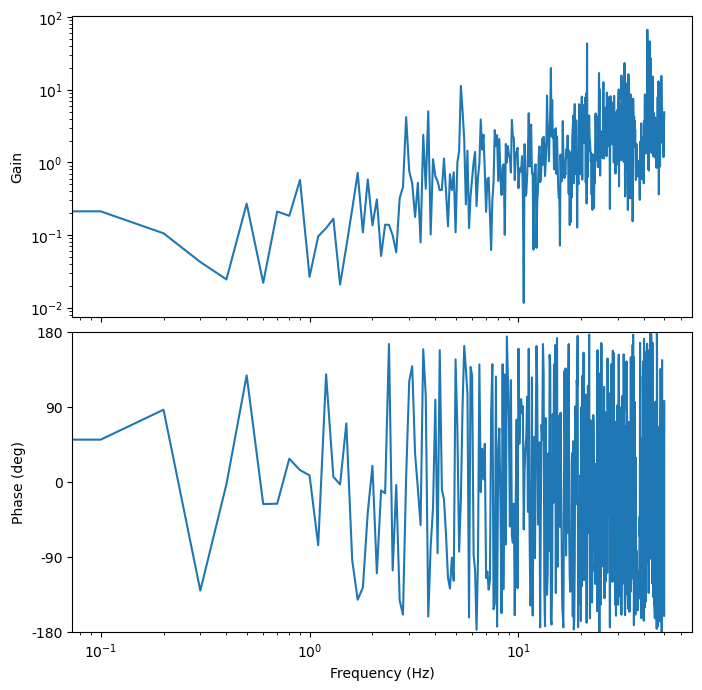

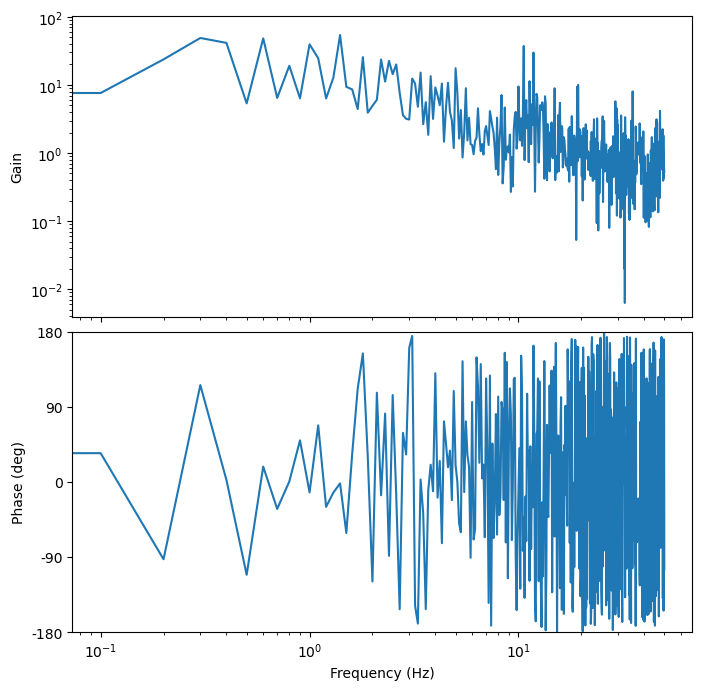

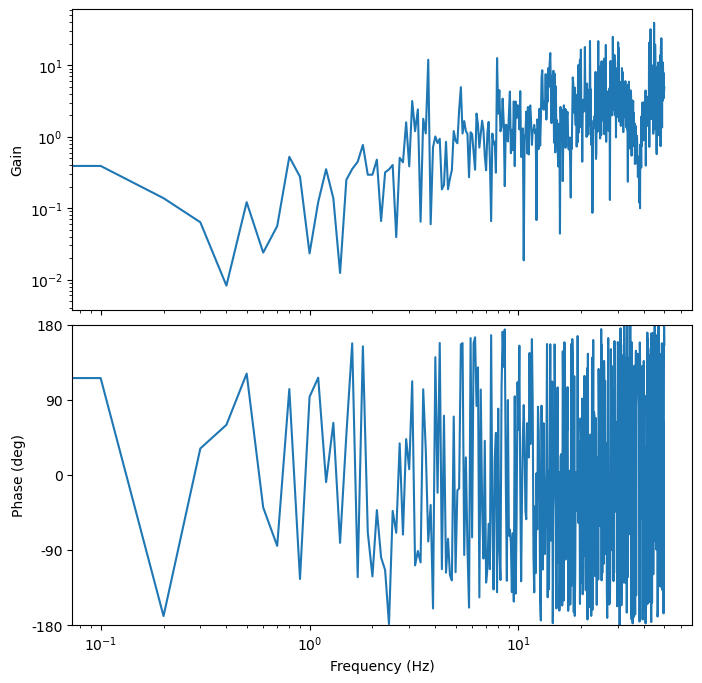

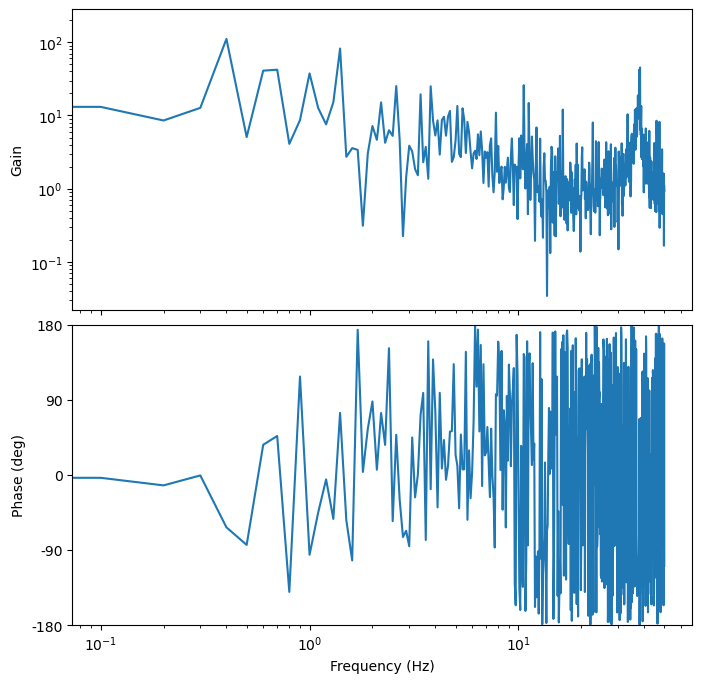

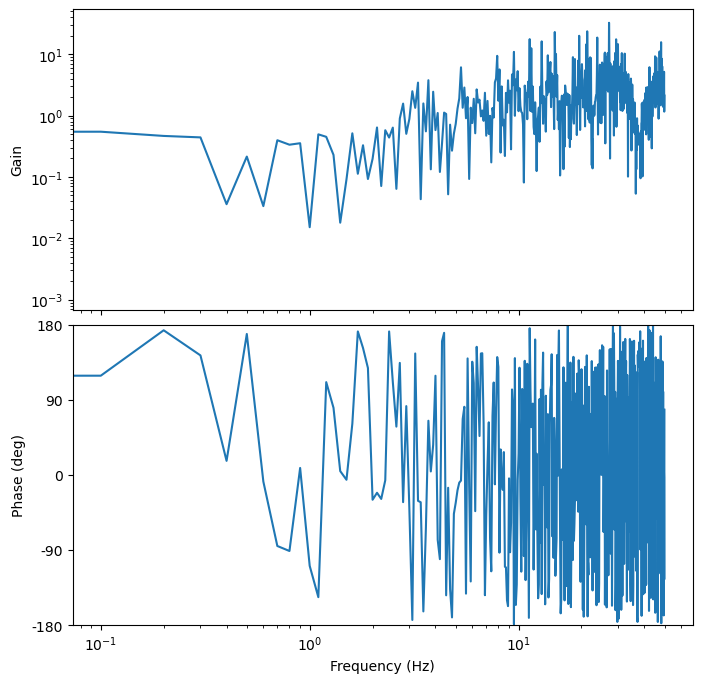

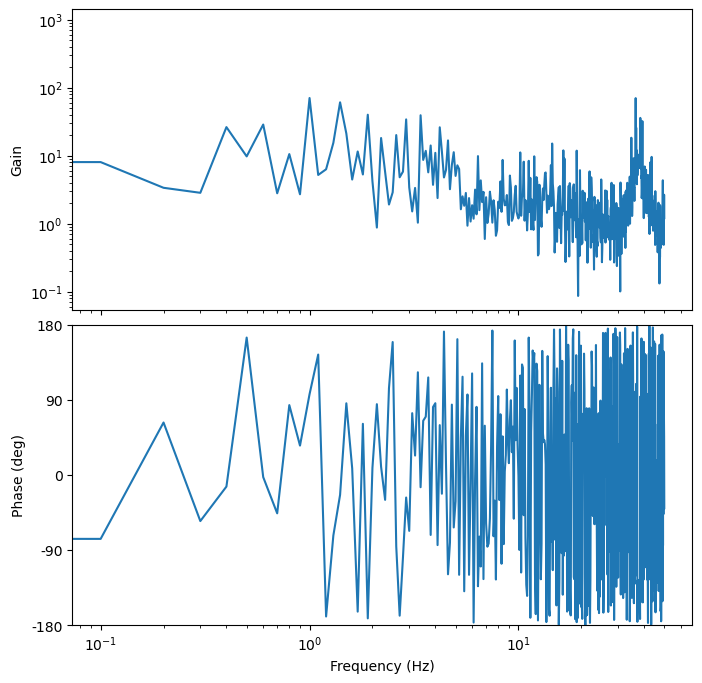

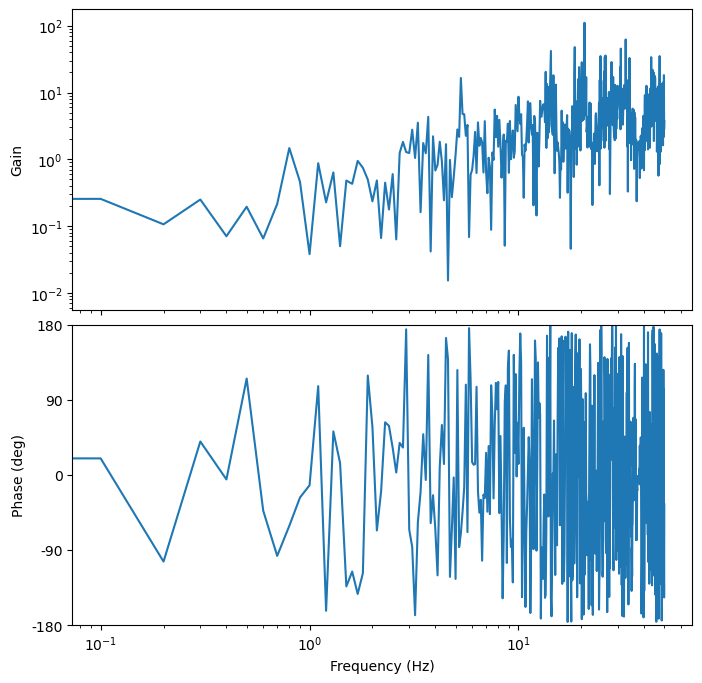

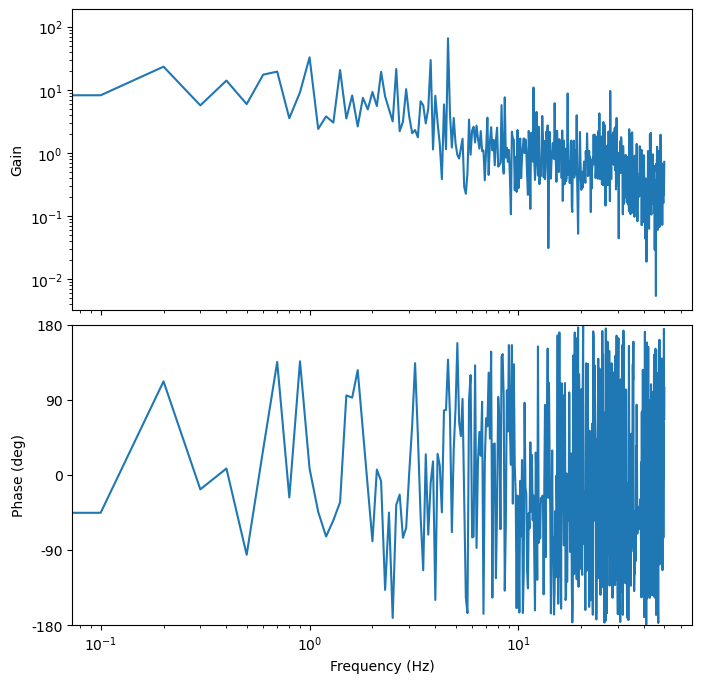

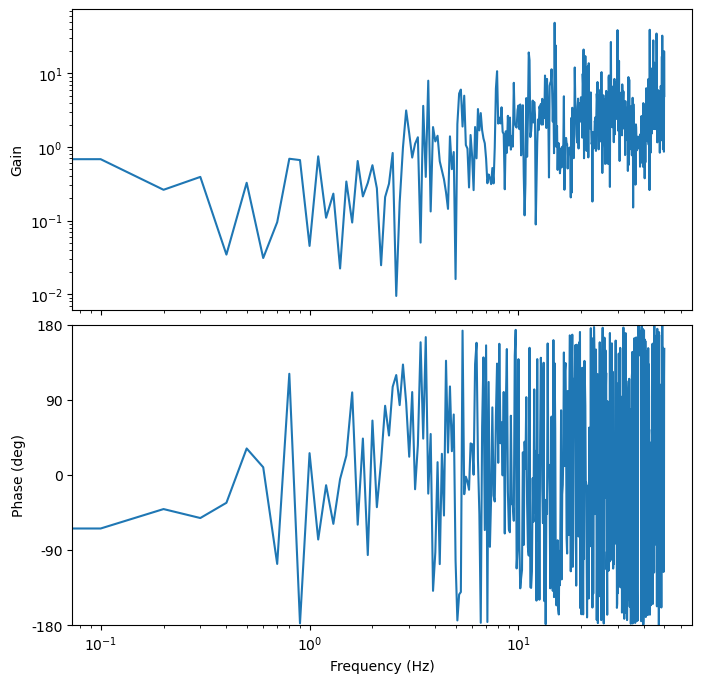

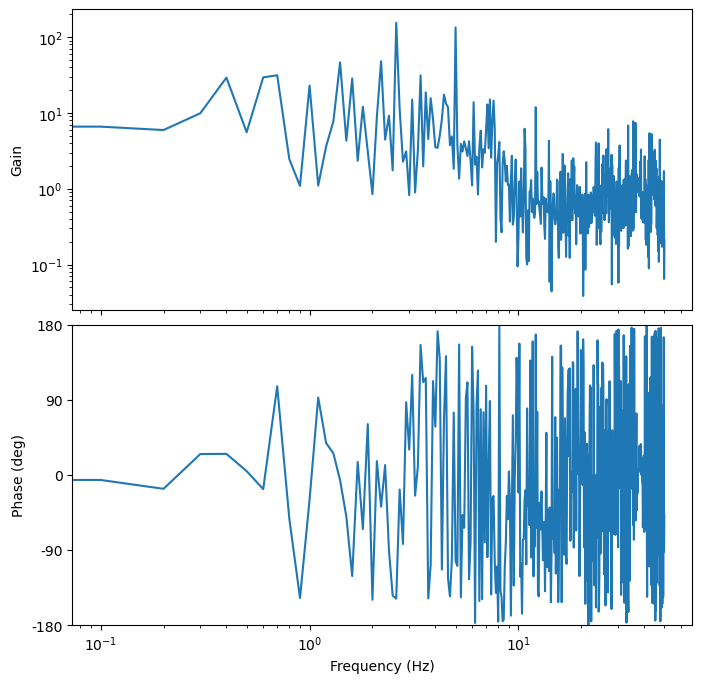

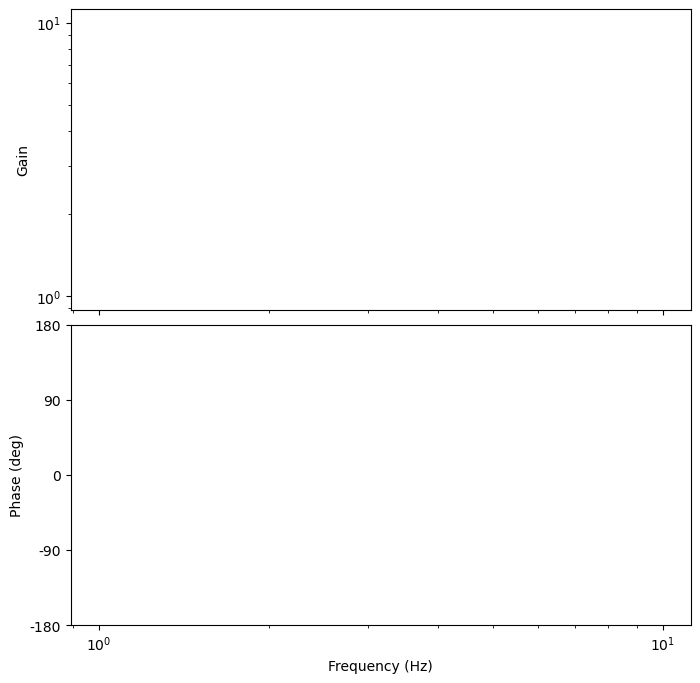

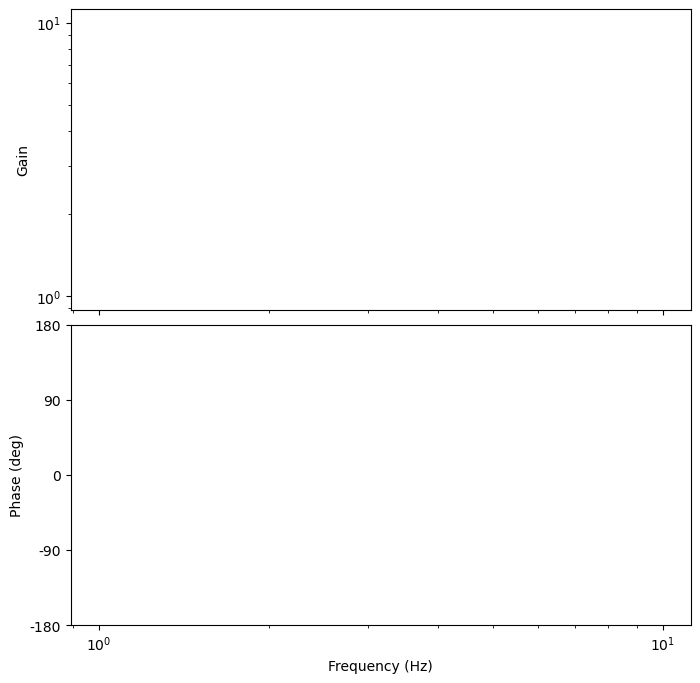

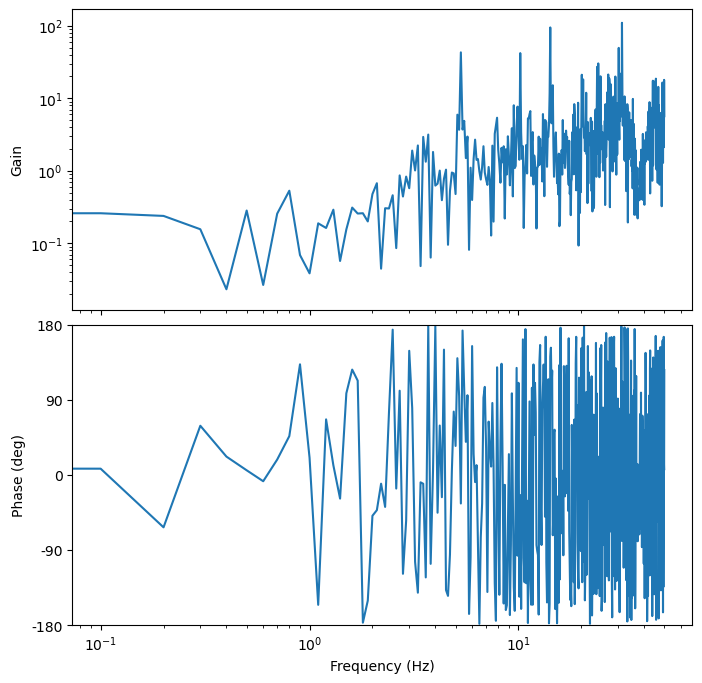

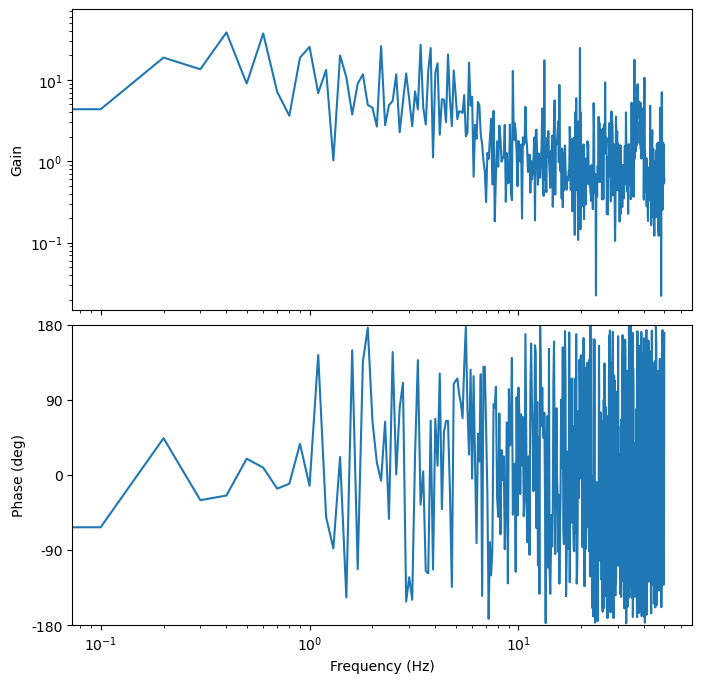

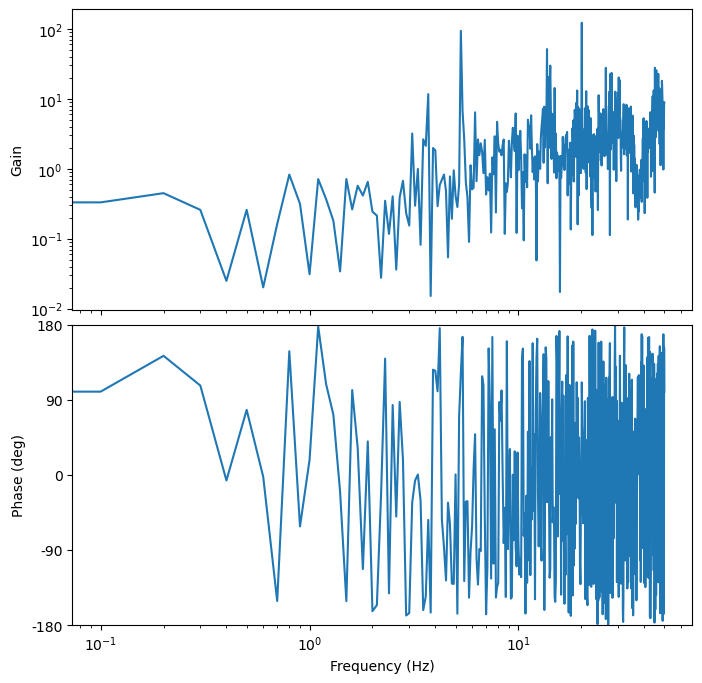

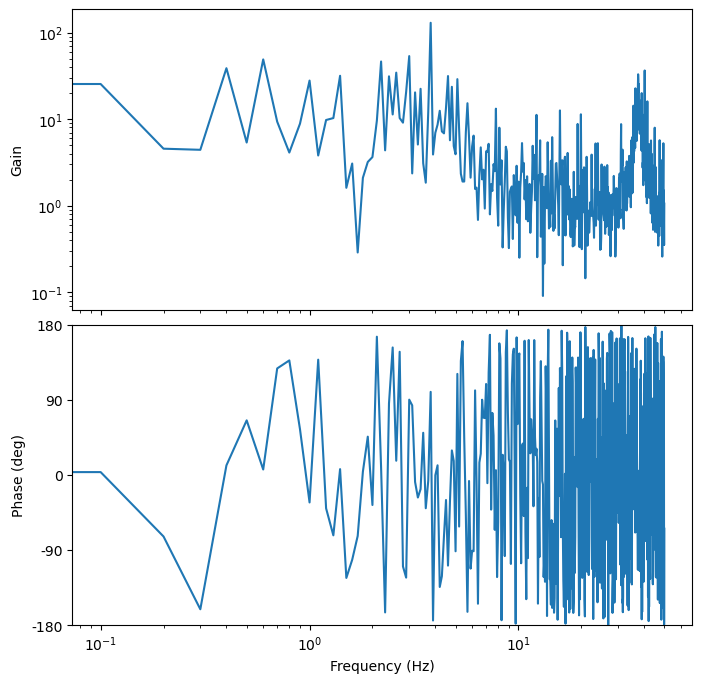

In [10]:
framerate = 100
dt = 1/framerate

fig_directory_Bode = './dataFolder/TrackingData_2022_11_10/ErrorAngle/Plots/Bode/'

for f in pilifer_signal_files:
    pilifer_signal = pd.read_csv(f, index_col=0)
    mothID = f.split('\\')[-1][:-15]
    
    trackPoints = pd.read_csv([file for file in trackPoints_files if mothID in file][0], index_col=0)
    
    pilifer_signal_smooth = signal.savgol_filter(pilifer_signal.values.flatten(), 5, 3)
    pilifer_signal_smooth_deg = pilifer_signal_smooth*(180/np.pi)
    
    body_lateral = trackPoints.loc[:,'body_x']
    body_smooth = signal.savgol_filter(body_lateral, 5, 3)
    nectary_lateral = trackPoints.loc[:,'nectary_x']
    nectary_smooth = signal.savgol_filter(nectary_lateral, 5, 3)
                                       
    pilifer_fft, freq = half_fft(pilifer_signal_smooth_deg, dt = dt)
    body_fft, freq = half_fft(body_smooth, dt = dt)
    nectary_fft, freq = half_fft(nectary_smooth, dt = dt)
    
    f, ax = plotBode(u = nectary_smooth, y = pilifer_signal_smooth_deg, t=None, dt=dt, u_thresh = None, ax=None)
    f.savefig(fig_directory_Bode + mothID + 'nectary_pilifer_bode.png')
    
    f1, ax1 = plotBode(u = pilifer_signal_smooth_deg, y = body_smooth, t=None, dt=dt, u_thresh = None, ax=None)
    f1.savefig(fig_directory_Bode + mothID + 'pilifer_body_bode.png')

In [5]:
pilifer_signal_files

['./dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m11_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m13_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m14_130806_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m1_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m4_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m5_130802_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m8_130805_errorAngle.csv',
 './dataFolder/TrackingData_2022_11_10/ErrorAngle/MV_fixed\\MV_m9_130801_errorAngle.csv']

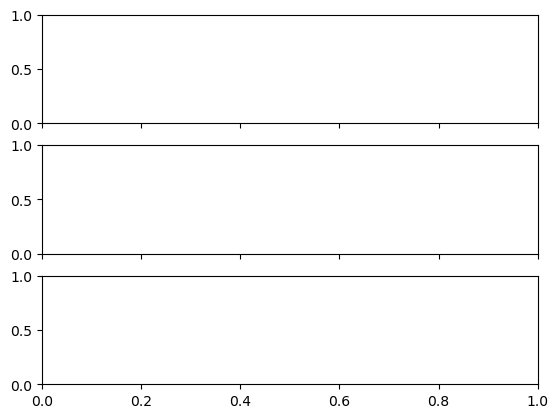

In [12]:
framerate = 100
dt = 1/framerate

fig1, ax = plt.subplots(3,1, sharex= True)
ax = ax.ravel()

fig_directory_RawFFT = './dataFolder/TrackingData_2022_11_10/ErrorAngle/Plots/RawFFT/'

for f in pilifer_signal_files:
    pilifer_signal = pd.read_csv(f, index_col=0)
    mothID = f.split('\\')[-1][:-15]
    
    trackPoints = pd.read_csv([file for file in trackPoints_files if mothID in file][0], index_col=0)
    
    pilifer_signal_smooth = signal.savgol_filter(pilifer_signal.values.flatten(), 5, 3)
    pilifer_signal_smooth_deg = pilifer_signal_smooth*(180/np.pi)
    
    body_lateral = trackPoints.loc[:,'body_x']
    body_smooth = signal.savgol_filter(body_lateral, 5, 3)
    nectary_lateral = trackPoints.loc[:,'nectary_x']
    nectary_smooth = signal.savgol_filter(nectary_lateral, 5, 3)
                                       
    
    pilifer_fft, freq = half_fft(pilifer_signal_smooth_deg, dt = dt)
    body_fft, freq = half_fft(body_smooth, dt = dt)
    nectary_fft, freq = half_fft(nectary_smooth, dt = dt)
    
    makeFFT(freq, pilifer=pilifer_fft, body=body_fft, nectary=nectary_fft, ax=ax)
    fig1.savefig(fig_directory_RawFFT + mothID + '_rawFFT.png')
    for axes in ax:
        axes.clear()

In [ ]:
# dt = 0.025
# t = np.arange(0, 20, dt)

# u = 2 + 6*np.cos(2*np.pi*t+0.2) + 10*np.sin(10*np.pi*t + 1.5)
# y = 2 + 5*np.cos(2*np.pi*t) + 7*np.sin(10*np.pi*t + 0.5)+3*np.random.randn(len(t))

# plt.plot(t,u)
# plt.plot(t, y)
# plt.show()

In [ ]:
y_fft = np.fft.fft(nectary_lateral, norm = 'forward')
freq = np.fft.fftfreq(len(y_fft), dt)

fidx = freq>=0
freq=freq[fidx]
y_fft = y_fft[fidx]

y_fft[1:]*=2

plt.plot(freq, np.abs(y_fft))
plt.xlim(0.1,15)
plt.ylim(0, 50)

thresh = 1.5
freqs = signal.find_peaks(y_fft, threshold = 0.1)[0]
# np.where(np.abs(y_fft)>=thresh)
plt.plot(freq[freqs], np.abs(y_fft[freqs]), 'or')



plt.show()

In [ ]:
fig, ax = plotBode(u = nectary_lateral, y = body_lateral, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.1
                   , marker = '.', linestyle = '--')
ax[0].set_ylim([0.1, 20])
plt.show()

In [ ]:
fig, ax = plotBode(u = nectary_lateral, y = pilifer_signal, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.01
                   , marker = '.', linestyle = '--')
# ax[0].set_ylim([0.1, 1.1])
plt.show()

In [ ]:
fig, ax = plotBode(u = pilifer_signal, y = body_lateral, t = None, dt = dt
                   , freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7, 19.9]
#                    , u_thresh = 0.01
                   , marker = '.', linestyle = '--')
# ax[0].set_ylim([0.1, 1.1])
plt.show()

In [ ]:
freqs = [0.2, 0.3, 0.5, 0.7, 1.1, 1.7, 2.9, 4.3, 7.9, 13.7]

In [ ]:
freq_idx = [np.where(np.round(freq, decimals=1) == f) for f in freqs]
freq_idx

In [ ]:
for f in freqs:
    print(f)
    print(np.where(np.round(freq, decimals=1) == f))